In [48]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [49]:
print("Tensorflow version: ", tf.__version__)
print(tf.config.list_physical_devices("GPU"))

Tensorflow version:  2.9.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [50]:
dir_path = os.path.join("database", "text_classification")

with open (os.path.join(dir_path, "en.json")) as f:
    data = json.load(f)
    df = pd.DataFrame(data)

df

,text,label
0,Did a pain in the center of the chest ever occ...,chest_pain
1,Did those symptoms changes?,symptoms_changes
2,Did you experienced fainting?,fainting_symptoms
3,Did you faint?,fainting_symptoms
4,Did you had a cough with sputum?,cough_symptoms
...,...,...
71,visit reason,visit_reason
72,visit reason?,visit_reason
73,when did the symptoms start,symptoms_start
74,why are you in the hospital?,visit_reason


In [51]:
df.drop_duplicates(["text"], ignore_index=True)

,text,label
0,Did a pain in the center of the chest ever occ...,chest_pain
1,Did those symptoms changes?,symptoms_changes
2,Did you experienced fainting?,fainting_symptoms
3,Did you faint?,fainting_symptoms
4,Did you had a cough with sputum?,cough_symptoms
...,...,...
71,visit reason,visit_reason
72,visit reason?,visit_reason
73,when did the symptoms start,symptoms_start
74,why are you in the hospital?,visit_reason


In [52]:
df["label"].value_counts()

visit_reason              12
symptoms_start             9
greetings                  8
fever_symptoms             6
diseases_parents           6
surgeries                  5
symptoms_circumstances     5
chest_pain                 4
symptoms_changes           4
fainting_symptoms          4
diseases_personal          4
cough_symptoms             3
palpitations_symptoms      3
chronic_treatment          3
Name: label, dtype: int64

In [53]:
dir_path = os.path.join("database", "personas")

with open(os.path.join(dir_path, "en_personas.json")) as f:
    data = json.load(f)
    texts = []
    labels = []
    for persona in data:
        for dialog_entity in persona["dialog"]:
            if not "questions" in dialog_entity:
                print(dialog_entity)
            
            for question in dialog_entity["questions"]:
                texts.append(question)
                labels.append(dialog_entity["label"])
    df_persona = pd.DataFrame(
        {
            "text": texts,
            "label": labels
        }
    )
df_persona.head()

,text,label
0,What is the reason for the presentation at the...,visit_reason
1,When did the symptoms start?,symptoms_start
2,What are the circumstances of the onset of sym...,symptoms_circumstances
3,Were there any changes in symptoms from onset ...,symptoms_changes
4,Do you know of any illness that your mother or...,diseases_parents


In [54]:
df_persona = df_persona.drop_duplicates(["text"], ignore_index=True)

In [55]:
df_combined = pd.concat([df, df_persona], ignore_index=True)
label_to_idx = {label: idx for idx, label in enumerate(df_combined["label"].unique())}
label_to_idx

{'chest_pain': 0,
 'symptoms_changes': 1,
 'fainting_symptoms': 2,
 'cough_symptoms': 3,
 'surgeries': 4,
 'fever_symptoms': 5,
 'palpitations_symptoms': 6,
 'chronic_treatment': 7,
 'diseases_parents': 8,
 'diseases_personal': 9,
 'greetings': 10,
 'symptoms_start': 11,
 'symptoms_circumstances': 12,
 'visit_reason': 13}

In [56]:
df_combined["label_id"] = df_combined["label"].apply(lambda s: label_to_idx[s])
df_combined.head()

,text,label,label_id
0,Did a pain in the center of the chest ever occ...,chest_pain,0
1,Did those symptoms changes?,symptoms_changes,1
2,Did you experienced fainting?,fainting_symptoms,2
3,Did you faint?,fainting_symptoms,2
4,Did you had a cough with sputum?,cough_symptoms,3


In [57]:
train_df = df_combined.groupby("label").sample(frac=0.8, random_state=42)
valid_df = df_combined.drop(train_df.index)

In [58]:
batch_size = 12

train_dataset = (tf.data.Dataset
                 .from_tensor_slices((train_df["text"], train_df["label_id"]))
                 .batch(batch_size))

valid_dataset = (tf.data.Dataset
                 .from_tensor_slices((valid_df["text"], valid_df["label_id"]))
                 .batch(batch_size))

In [59]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2",
    trainable=True)

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/2",
#     trainable=True)

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/2",
#     trainable=True)

encoder_outputs = encoder(encoder_inputs)
outputs = tf.keras.layers.Dense(len(label_to_idx), name="class_output")(encoder_outputs["pooled_output"])

model = tf.keras.Model(inputs=text_input, outputs=[outputs, encoder_outputs["pooled_output"]])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_word_ids':   0           ['input_2[0][0]']                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [60]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss={
        "class_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    },
    metrics={
        "class_output": [tf.keras.metrics.SparseCategoricalAccuracy()]
    }
)

In [61]:
epochs = 100

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset
)

Epoch 1/100
7/7 [==============================] - 20s 2s/step - loss: 2.9789 - class_output_loss: 2.9789 - class_output_sparse_categorical_accuracy: 0.0476 - val_loss: 2.8619 - val_class_output_loss: 2.8619 - val_class_output_sparse_categorical_accuracy: 0.1364
Epoch 2/100
7/7 [==============================] - 2s 327ms/step - loss: 2.8761 - class_output_loss: 2.8761 - class_output_sparse_categorical_accuracy: 0.0952 - val_loss: 2.7728 - val_class_output_loss: 2.7728 - val_class_output_sparse_categorical_accuracy: 0.1364
Epoch 3/100
7/7 [==============================] - 2s 318ms/step - loss: 2.7707 - class_output_loss: 2.7707 - class_output_sparse_categorical_accuracy: 0.1310 - val_loss: 2.6859 - val_class_output_loss: 2.6859 - val_class_output_sparse_categorical_accuracy: 0.1818
Epoch 4/100
7/7 [==============================] - 2s 308ms/step - loss: 2.6992 - class_output_loss: 2.6992 - class_output_sparse_categorical_accuracy: 0.1310 - val_loss: 2.6057 - val_class_output_loss: 2.60

In [62]:
# def cosine(v1, v2):
#     dot_product = np.dot(v1, v2)
#     denominator = np.linalg.norm(v1) * np.linalg.norm(v2)
#     result = dot_product / denominator
#     if result > 1.0:
#         return 1.0
#     elif result < -1.0:
#         return -1.0
#     else:
#         return result

# def TS(v1, v2):
#     theta = np.arccos(cosine(v1, v2)) + np.radians(10)
#     return np.linalg.norm(v1) * np.linalg.norm(v2) * np.sin(theta) / 2

# def SS(v1, v2):
#     ED = np.linalg.norm(v1 - v2)
#     MD = np.abs(np.linalg.norm(v1) - np.linalg.norm(v2))
#     theta = np.arccos(cosine(v1, v2)) + np.radians(10)
#     return np.pi * (ED + MD)**2 * theta / 360

# def TS_SS(v1, v2):
#     return TS(v1, v2) * SS(v1, v2)

# def similarity(v1, v2):
#     return TS_SS(v1, v2)

In [63]:
# test_utterances = ["hello there", "Hello", "Why are you here", "Good evening"]
# idx_to_label = {v: k for k, v in label_to_idx.items()}

# class_predict, embeddings = model.predict(test_utterances)
# class_predict_idx = np.argmax(class_predict, axis=1)

# for utterance, idx in zip(test_utterances, class_predict_idx):
#     print(utterance, f"({idx_to_label[idx]})")

# for utterance1, embedding1 in zip(test_utterances, embeddings):
#     for utterance2, embedding2 in zip(test_utterances, embeddings):
#         print(f"{utterance1} <-> {utterance2} ({similarity(embedding1, embedding2)}) (ts: {TS(embedding1, embedding2)}, ss: {SS(embedding1, embedding2)})")

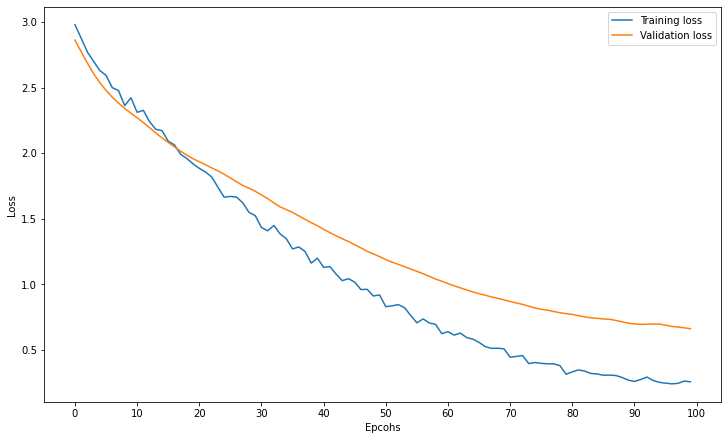

In [64]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
ax.plot(history.history["loss"], label="Training loss")
ax.plot(history.history["val_loss"], label="Validation loss")
ax.set_xlabel("Epcohs")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, len(history.history["loss"]) + 1, 10))
ax.legend()
plt.savefig("loss.png")

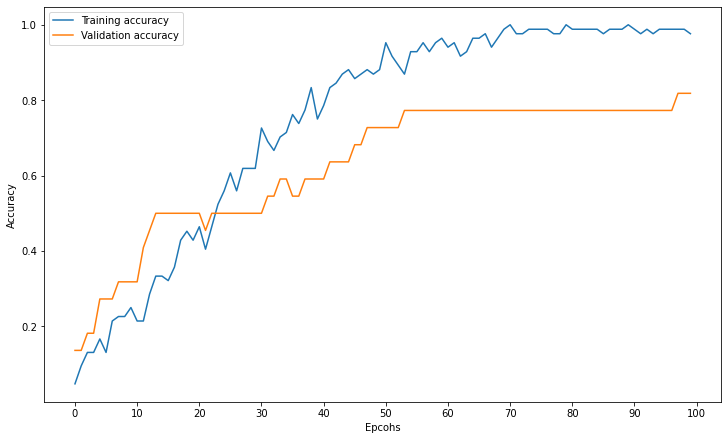

In [65]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
ax.plot(history.history["class_output_sparse_categorical_accuracy"], label="Training accuracy")
ax.plot(history.history["val_class_output_sparse_categorical_accuracy"], label="Validation accuracy")
ax.set_xlabel("Epcohs")
ax.set_ylabel("Accuracy")
ax.set_xticks(np.arange(0, len(history.history["class_output_sparse_categorical_accuracy"]) + 1, 10))
ax.legend()
fig.savefig("accuracy.png")

In [66]:
metrics = model.evaluate(
    df_combined["text"].to_numpy(),
    df_combined["label_id"].to_numpy()
)

for metric_name, metric in zip(model.metrics_names, metrics):
    print(f"{metric_name:<8s}: {metric:.4f}")

4/4 [==============================] - 1s 255ms/step - loss: 0.2220 - class_output_loss: 0.2220 - class_output_sparse_categorical_accuracy: 0.9623
loss    : 0.2220
class_output_loss: 0.2220
class_output_sparse_categorical_accuracy: 0.9623


In [67]:
predictions_probabilities, embeddings = model.predict(df_combined["text"])
predictions = np.argmax(predictions_probabilities, axis=1)

y_true = df_combined["label_id"].to_numpy()
accuracy = accuracy_score(y_true, predictions)
precision = precision_score(y_true, predictions, average="macro")
recall = precision_score(y_true, predictions, average="macro")
f1score = f1_score(y_true, predictions, average="macro")

print(f"accuracy : {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall   : {recall:.4f}")
print(f"F1       : {f1score:.4f}")

4/4 [==============================] - 2s 328ms/step
accuracy : 0.9623
precision: 0.9643
recall   : 0.9643
F1       : 0.9529


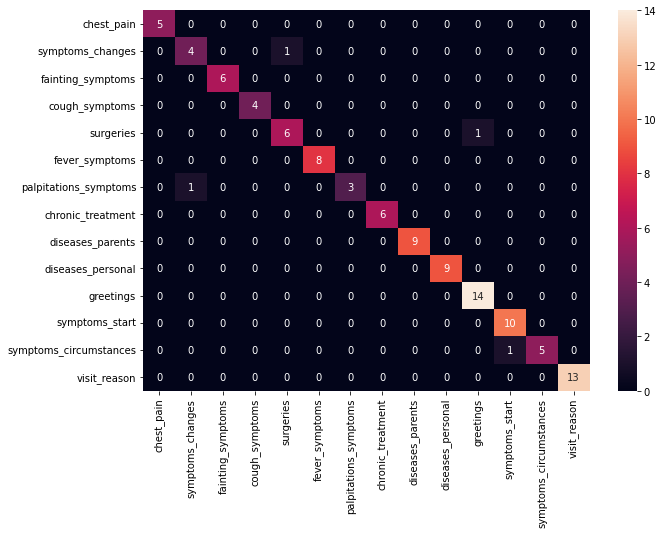

In [68]:
matrix = confusion_matrix(y_true, predictions)
index = label_to_idx.keys()
df = pd.DataFrame(matrix, index=index, columns=index)
plt.figure(figsize=(10, 7))
sns.heatmap(df, annot=True, fmt="d")
plt.savefig("confusion_matrix.png")

In [69]:
model.save("bert_classification")

INFO:tensorflow:Assets written to: bert_classification\assets


INFO:tensorflow:Assets written to: bert_classification\assets
